# Semi-Supervised Learning

<img src="https://user-images.githubusercontent.com/35906602/209691881-e66c74d1-ad00-416f-ae22-581ab6a37ed5.png" width=800>

Semi-Supervised Learning이란 적은 량의 labeled data와 대용량의 unlabeled data가 존재할 때, 적은 량의 labeled data에는 지도 학습을 적용하고 나머지 대용량의 unlabeled data에는 비지도 학습을 적용하는 방법론입니다. 이를 통해 적은 량의 labeled data에 비해 더 많은 정보를 활용하여 성능 향상을 끌어낼 수 있습니다.

SSL에선 일반적으로 3가지 가정이 이야기 됩니다.

* (semi-supervised) smoothness 가정 : Smoothness 가정은 확률 밀도가 높은 지역의 입력값 $x_1$가 가깝다면, 각각에 연관된 레이블 $y_1, y_2$도 그래야 한다는 것입니다.
* low-density 가정 : low-density 가정은 모델의 결정 경계가 데이터의 확률 밀도가 높은 곳을 지나지 않는다는 가정입니다. 
low-density 가정은 smoothness 가정과 연관성이 있는데, low-density 가정에 따라 모델의 결정 경계를 두면 low-density 지역은 그 주변에 데이터들이 적기 때문에 smoothness 가정을 위반하지 않습니다.
* manifold 가정 : Manifold 가정은 앞의 가정들과 비슷한데, 고차원의 입력 데이터가 저차원 공간에서 특정한 구조[manifold]를 따라 놓여 있다는 것입니다. 이는 입력 데이터가 실제로는 여러 개의 저차원 manifold의 결합으로 이루어져 있다는 것과, 같은 manifold 상의 데이터는 같은 레이블을 가지고 있다는 것을 의미합니다.

SSL은 분야가 큰 만큼 다양한 종류의 알고리즘이 제안되었습니다. 이러한 알고리즘들은 알고리즘을 기반에 둔 가정, 레이블되지 않은 데이터의 사용 방식, SL과의 연관 관계 등에서 차이를 가집니다. 

*이미지 및 설명 출처 : https://blog.est.ai/2020/11/ssl/*

# Tutorial 시작

코드 출처 : https://github.com/perrying/realistic-ssl-evaluation-pytorch

본 튜토리얼은 위의 코드를 참고하여 작성 되었습니다.

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import argparse, math, time, json, os

from lib import wrn, transform

## 0. Dataset 준비

<img src=https://user-images.githubusercontent.com/35906602/209686848-82a1e67e-33dd-4036-aaf9-26493b442a0b.png width="600">

* 이미지 출처 : https://gruuuuu.github.io/machine-learning/cifar10-cnn/

본 튜토리얼에서는 Cifar-10 데이터셋이 활용되었습니다. Cifar-10 데이터셋은 32x32 픽셀의 60,000개의 컬러 이미지로 구성된 데이터로, 각 이미지는 총 10개의 클래스로 라벨링 되어 있습니다.

In [3]:
from torchvision import datasets
import argparse, os
import numpy as np

parser = argparse.ArgumentParser()
parser.add_argument("--seed", "-s", default=1, type=int, help="random seed")
parser.add_argument("--dataset", "-d", default="cifar10", type=str, help="dataset name : [cifar10]") # Cifar10 사용
parser.add_argument("--nlabels", "-n", default=1000, type=int, help="the number of labeled data")
args = parser.parse_args("")

COUNTS = {
    "cifar10": {"train": 50000, "test": 10000, "valid": 5000, "extra": 0},
    "imagenet_32": {
        "train": 1281167,
        "test": 50000,
        "valid": 50050,
        "extra": 0,
    },
}

_DATA_DIR = "./data"

def split_l_u(train_set, n_labels):
    # NOTE: this function assume that train_set is shuffled.
    images = train_set["images"]
    labels = train_set["labels"]
    classes = np.unique(labels)
    n_labels_per_cls = n_labels // len(classes)
    l_images = []
    l_labels = []
    u_images = []
    u_labels = []
    for c in classes:
        cls_mask = (labels == c)
        c_images = images[cls_mask]
        c_labels = labels[cls_mask]
        l_images += [c_images[:n_labels_per_cls]]
        l_labels += [c_labels[:n_labels_per_cls]]
        u_images += [c_images[n_labels_per_cls:]]
        u_labels += [np.zeros_like(c_labels[n_labels_per_cls:]) - 1] # dammy label
    l_train_set = {"images": np.concatenate(l_images, 0), "labels": np.concatenate(l_labels, 0)}
    u_train_set = {"images": np.concatenate(u_images, 0), "labels": np.concatenate(u_labels, 0)}
    return l_train_set, u_train_set

def _load_cifar10():
    splits = {}
    for train in [True, False]:
        tv_data = datasets.CIFAR10(_DATA_DIR, train, download=True)
        data = {}
        data["images"] = tv_data.data
        data["labels"] = np.array(tv_data.targets)
        splits["train" if train else "test"] = data
    return splits.values()

def gcn(images, multiplier=55, eps=1e-10):
    # global contrast normalization
    images = images.astype(np.float)
    images -= images.mean(axis=(1,2,3), keepdims=True)
    per_image_norm = np.sqrt(np.square(images).sum((1,2,3), keepdims=True))
    per_image_norm[per_image_norm < eps] = 1
    return multiplier * images / per_image_norm

def get_zca_normalization_param(images, scale=0.1, eps=1e-10):
    n_data, height, width, channels = images.shape
    images = images.reshape(n_data, height*width*channels)
    image_cov = np.cov(images, rowvar=False)
    U, S, _ = np.linalg.svd(image_cov + scale * np.eye(image_cov.shape[0]))
    zca_decomp = np.dot(U, np.dot(np.diag(1/np.sqrt(S + eps)), U.T))
    mean = images.mean(axis=0)
    return mean, zca_decomp

def zca_normalization(images, mean, decomp):
    n_data, height, width, channels = images.shape
    images = images.reshape(n_data, -1)
    images = np.dot((images - mean), decomp)
    return images.reshape(n_data, height, width, channels)

rng = np.random.RandomState(args.seed)

validation_count = COUNTS[args.dataset]["valid"]

extra_set = None  # In general, there won't be extra data.

train_set, test_set = _load_cifar10()
train_set["images"] = gcn(train_set["images"])
test_set["images"] = gcn(test_set["images"])
mean, zca_decomp = get_zca_normalization_param(train_set["images"])
train_set["images"] = zca_normalization(train_set["images"], mean, zca_decomp)
test_set["images"] = zca_normalization(test_set["images"], mean, zca_decomp)
# N x H x W x C -> N x C x H x W
train_set["images"] = np.transpose(train_set["images"], (0,3,1,2))
test_set["images"] = np.transpose(test_set["images"], (0,3,1,2))

# permute index of training set
indices = rng.permutation(len(train_set["images"]))
train_set["images"] = train_set["images"][indices]
train_set["labels"] = train_set["labels"][indices]

if extra_set is not None:
    extra_indices = rng.permutation(len(extra_set["images"]))
    extra_set["images"] = extra_set["images"][extra_indices]
    extra_set["labels"] = extra_set["labels"][extra_indices]

# split training set into training and validation
train_images = train_set["images"][validation_count:]
train_labels = train_set["labels"][validation_count:]
validation_images = train_set["images"][:validation_count]
validation_labels = train_set["labels"][:validation_count]
validation_set = {"images": validation_images, "labels": validation_labels}
train_set = {"images": train_images, "labels": train_labels}

# split training set into labeled data and unlabeled data
l_train_set, u_train_set = split_l_u(train_set, args.nlabels)

if not os.path.exists(os.path.join(_DATA_DIR, args.dataset)):
    os.mkdir(os.path.join(_DATA_DIR, args.dataset))

np.save(os.path.join(_DATA_DIR, args.dataset, "l_train"), l_train_set)
np.save(os.path.join(_DATA_DIR, args.dataset, "u_train"), u_train_set)
np.save(os.path.join(_DATA_DIR, args.dataset, "val"), validation_set)
np.save(os.path.join(_DATA_DIR, args.dataset, "test"), test_set)
if extra_set is not None:
    np.save(os.path.join(_DATA_DIR, args.dataset, "extra"), extra_set)


Files already downloaded and verified
Files already downloaded and verified


## 0. 공통 설정

밑의 파라미터는 모든 학습에서 공유하게 됩니다. 

기존에는 50만 이상의 많은 수의 Iteration을 필요로 하나, 학습 시간의 문제로 본 튜토리얼에서는 10,000번의 Iteration으로 학습하게 됩니다. 따라서 기존에 알려진 성능보다 낮은 성능을 보인다는 점을 주의해주세요.

In [4]:
device = "cuda"

In [5]:
parser = argparse.ArgumentParser()
parser.add_argument("--alg", "-a", default="VAT", type=str, help="ssl algorithm : [supervised, PI, MT, VAT, PL, ICT]")
parser.add_argument("--em", default=0, type=float, help="coefficient of entropy minimization. If you try VAT + EM, set 0.06")
parser.add_argument("--validation", default=1000, type=int, help="validate at this interval (default 25000)")
parser.add_argument("--dataset", "-d", default="cifar10", type=str, help="dataset name : [cifar10]")
parser.add_argument("--root", "-r", default="data", type=str, help="dataset dir")
parser.add_argument("--output", "-o", default="./exp_res", type=str, help="output dir")
args = parser.parse_args("")

In [6]:
shared_config = {
    "iteration" : 10000,
    "warmup" : 4000,
    "lr_decay_iter" : 8000,
    "lr_decay_factor" : 0.2,
    "batch_size" : 100,
}

In [7]:
class RandomSampler(torch.utils.data.Sampler):
    """ sampling without replacement """
    def __init__(self, num_data, num_sample):
        iterations = num_sample // num_data + 1
        self.indices = torch.cat([torch.randperm(num_data) for _ in range(iterations)]).tolist()[:num_sample]

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)

### Dataset

딥러닝 모델을 학습시키기 위한 데이터셋을 구성하는 단계입니다.

In [8]:
class CIFAR10:
    def __init__(self, root, split="l_train"):
        self.dataset = np.load(os.path.join(root, "cifar10", split+".npy"), allow_pickle=True).item()

    def __getitem__(self, idx):
        image = self.dataset["images"][idx]
        label = self.dataset["labels"][idx]
        return image, label

    def __len__(self):
        return len(self.dataset["images"])

In [9]:
cifar10_config = {
    "transform" : [True, True, True], # 차례대로 Horizontal flip, Random crop, Gaussian Noise를 의미합니다.
    "dataset" : CIFAR10,
    "num_classes" : 10,
}

In [10]:
dataset_cfg = cifar10_config
transform_fn = transform.transform(*dataset_cfg["transform"])

l_train_dataset = dataset_cfg["dataset"](args.root, "l_train")
u_train_dataset = dataset_cfg["dataset"](args.root, "u_train")
val_dataset = dataset_cfg["dataset"](args.root, "val")
test_dataset = dataset_cfg["dataset"](args.root, "test")

print("labeled data : {}, unlabeled data : {}, training data : {}".format(
    len(l_train_dataset), len(u_train_dataset), len(l_train_dataset)+len(u_train_dataset)))
print("validation data : {}, test data : {}".format(len(val_dataset), len(test_dataset)))


holizontal flip : True, random crop : True, gaussian noise : True
labeled data : 1000, unlabeled data : 44000, training data : 45000
validation data : 5000, test data : 10000


총 훈련 데이터 45,000개 중에 라벨 데이터는 1000개, 라벨이 없는 데이터는 44,000개이다. 검증 데이터의 경우에는 5,000개, 시험 데이터는 10,000개로 구성하였습니다.

In [11]:
l_loader = DataLoader(
    l_train_dataset, shared_config["batch_size"], drop_last=True,
    sampler=RandomSampler(len(l_train_dataset), shared_config["iteration"] * shared_config["batch_size"])
)

u_loader = DataLoader(
    u_train_dataset, shared_config["batch_size"]//2, drop_last=True,
    sampler=RandomSampler(len(u_train_dataset), shared_config["iteration"] * shared_config["batch_size"]//2)
)

val_loader = DataLoader(val_dataset, 128, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, 128, shuffle=False, drop_last=False)

### 학습 코드

학습 및 검증 단계에서 사용 할 학습 코드입니다.

In [12]:
def train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args):
    cls_loss_list = []
    ssl_loss_list = []
    loss_list = []
    val_acc_list = []

    iteration = 0
    maximum_val_acc = 0
    s = time.time()
    for l_data, u_data in zip(l_loader, u_loader):
        iteration += 1
        l_input, target = l_data
        l_input, target = l_input.to(device).float(), target.to(device).long()

        u_input, dummy_target = u_data
        u_input, dummy_target = u_input.to(device).float(), dummy_target.to(device).long()

        target = torch.cat([target, dummy_target], 0)
        unlabeled_mask = (target == -1).float()

        inputs = torch.cat([l_input, u_input], 0)
        outputs = model(inputs)

        # ramp up exp(-5(1 - t)^2)
        coef = alg_cfg["consis_coef"] * math.exp(-5 * (1 - min(iteration/shared_config["warmup"], 1))**2)
        ssl_loss = ssl_obj(inputs, outputs.detach(), model, unlabeled_mask) * coef

        # supervised loss
        cls_loss = F.cross_entropy(outputs, target, reduction="none", ignore_index=-1).mean()

        loss = cls_loss + ssl_loss

        ###
        cls_loss_list.append(cls_loss)
        ssl_loss_list.append(ssl_loss)
        loss_list.append(loss)
        ###

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if args.alg == "MT" or args.alg == "ICT":
            # parameter update with exponential moving average
            ssl_obj.moving_average(model.parameters())

        # 표기
        if iteration == 1 or (iteration % 100) == 0:
            wasted_time = time.time() - s
            rest = (shared_config["iteration"] - iteration)/100 * wasted_time / 60
            print("iteration [{}/{}] cls loss : {:.6e}, SSL loss : {:.6e}, coef : {:.5e}, time : {:.3f} iter/sec, rest : {:.3f} min, lr : {}".format(
                iteration, shared_config["iteration"], cls_loss.item(), ssl_loss.item(), coef, 100 / wasted_time, rest, optimizer.param_groups[0]["lr"]),
                "\r", end="")
            s = time.time()

        # Validation
        if (iteration % args.validation) == 0 or iteration == shared_config["iteration"]:
            with torch.no_grad():
                model.eval()
                print()
                print("### validation ###")
                sum_acc = 0.
                s = time.time()
                for j, data in enumerate(val_loader):
                    input, target = data
                    input, target = input.to(device).float(), target.to(device).long()

                    output = model(input)

                    pred_label = output.max(1)[1]
                    sum_acc += (pred_label == target).float().sum()
                    if ((j+1) % 10) == 0:
                        d_p_s = 10/(time.time()-s)
                        print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                            j+1, len(val_loader), d_p_s, (len(val_loader) - j-1)/d_p_s
                        ), "\r", end="")
                        s = time.time()
                acc = sum_acc/5000.0
                print()
                print("varidation accuracy : {}".format(acc))

                val_acc_list.append(acc)

                # Test
                if maximum_val_acc < acc:
                    print("### test ###")
                    maximum_val_acc = acc
                    sum_acc = 0.
                    s = time.time()
                    for j, data in enumerate(test_loader):
                        input, target = data
                        input, target = input.to(device).float(), target.to(device).long()
                        output = model(input)
                        pred_label = output.max(1)[1]
                        sum_acc += (pred_label == target).float().sum()
                        if ((j+1) % 10) == 0:
                            d_p_s = 100/(time.time()-s)
                            print("[{}/{}] time : {:.1f} data/sec, rest : {:.2f} sec".format(
                                j+1, len(test_loader), d_p_s, (len(test_loader) - j-1)/d_p_s
                            ), "\r", end="")
                            s = time.time()
                    print()
                    test_acc = sum_acc / 10000.0
                    print("test accuracy : {}".format(test_acc))
                    # torch.save(model.state_dict(), os.path.join(args.output, "best_model.pth"))
            model.train()
            s = time.time()

        # lr decay
        if iteration == shared_config["lr_decay_iter"]:
            optimizer.param_groups[0]["lr"] *= shared_config["lr_decay_factor"]    

    print("test acc : {}".format(test_acc))
    
    return cls_loss_list, ssl_loss_list, loss_list, val_acc_list, test_acc

## 1. VAT

<img src="https://user-images.githubusercontent.com/35906602/209687878-59d1e148-96db-4959-90ae-53096a6e8e71.png" width="700">

* Reference : https://creamnuts.github.io/short%20review/vat/
* Takeru Miyato. Virtual Adversarial Training: A Regularization Method for Supervised and Semi-Supervised Learning

Virtual Adversarial Training이란 Adversarial Training을 Semi-Supervised Learning에 접목한 방법론입니다. 라벨이 없는 데이터에 가상의 적대적 방향을 정의하고, 이 방향을 이용해 Adversarial Training을 수행하게 됩니다.



### Config

In [13]:
args.alg = 'VAT'
vat_config = {
    # virtual adversarial training
    "xi" : 1e-6,
    "eps" : {"cifar10":6},
    "consis_coef" : 0.3,
    "lr" : 3e-3
}
alg_cfg = vat_config

### Model

In [14]:
class VAT(nn.Module):
    def __init__(self, eps=1.0, xi=1e-6, n_iteration=1):
        super().__init__()
        self.eps = eps
        self.xi = xi
        self.n_iteration = n_iteration

    def kld(self, q_logit, p_logit):
        q = q_logit.softmax(1)
        qlogp = (q * self.__logsoftmax(p_logit)).sum(1)
        qlogq = (q * self.__logsoftmax(q_logit)).sum(1)
        return qlogq - qlogp

    def normalize(self, v):
        v = v / (1e-12 + self.__reduce_max(v.abs(), range(1, len(v.shape))))
        v = v / (1e-6 + v.pow(2).sum((1,2,3),keepdim=True)).sqrt()
        return v

    def forward(self, x, y, model, mask):
        model.update_batch_stats(False)
        d = torch.randn_like(x)
        d = self.normalize(d)
        for _ in range(self.n_iteration):
            d.requires_grad = True
            x_hat = x + self.xi * d
            y_hat = model(x_hat)
            kld = self.kld(y.detach(), y_hat).mean()
            d = torch.autograd.grad(kld, d)[0]
            d = self.normalize(d).detach()
        x_hat = x + self.eps * d
        y_hat = model(x_hat)
        # NOTE:
        # Original implimentation of VAT defines KL(P(y|x)||P(x|x+r_adv)) as loss function
        # However, Avital Oliver's implimentation use KL(P(y|x+r_adv)||P(y|x)) as loss function of VAT
        # see issue https://github.com/brain-research/realistic-ssl-evaluation/issues/27
        loss = (self.kld(y_hat, y.detach()) * mask).mean()
        model.update_batch_stats(True)
        return loss

    def __reduce_max(self, v, idx_list):
        for i in idx_list:
            v = v.max(i, keepdim=True)[0]
        return v

    def __logsoftmax(self,x):
        xdev = x - x.max(1, keepdim=True)[0]
        lsm = xdev - xdev.exp().sum(1, keepdim=True).log()
        return lsm

In [15]:
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])

trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

trainable parameters : 1467610


<img src="https://user-images.githubusercontent.com/35906602/209687686-e6183eae-6877-4d58-af50-f76481117eb9.png" width="800">

지도학습 모델은 WideResnet을 사용하게 됩니다. 이 튜토리얼에서는 SSL 방법론의 성능을 비교하기 위해 VAT를 비롯한 5개 SSL 모델 모두에서 해당 모델을 Backbone 모델로 통일하였습니다.

In [16]:
ssl_obj = VAT(alg_cfg["eps"][args.dataset], alg_cfg["xi"], 1)

### Train

In [17]:
VAT_cls_loss_list, VAT_ssl_loss_list, VAT_loss_list, VAT_val_acc_list, VAT_test_acc = train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args)

iteration [1000/10000] cls loss : 1.653344e-01, SSL loss : 2.709483e-02, coef : 1.80164e-02, time : 10.637 iter/sec, rest : 14.102 min, lr : 0.003 
### validation ###
[40/40] time : 116.2 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5424000024795532
### test ###
[70/79] time : 1231.5 data/sec, rest : 0.01 sec 
test accuracy : 0.5288999676704407
iteration [2000/10000] cls loss : 7.157332e-02, SSL loss : 8.026180e-02, coef : 8.59514e-02, time : 10.567 iter/sec, rest : 12.618 min, lr : 0.003 
### validation ###
[40/40] time : 118.7 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5491999983787537
### test ###
[70/79] time : 1218.4 data/sec, rest : 0.01 sec 
test accuracy : 0.5374999642372131
iteration [3000/10000] cls loss : 4.413806e-02, SSL loss : 1.486142e-01, coef : 2.19485e-01, time : 10.602 iter/sec, rest : 11.004 min, lr : 0.003 
### validation ###
[40/40] time : 120.6 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5643999576568604
### test ###
[70/79] time : 1259.0 dat

### Result

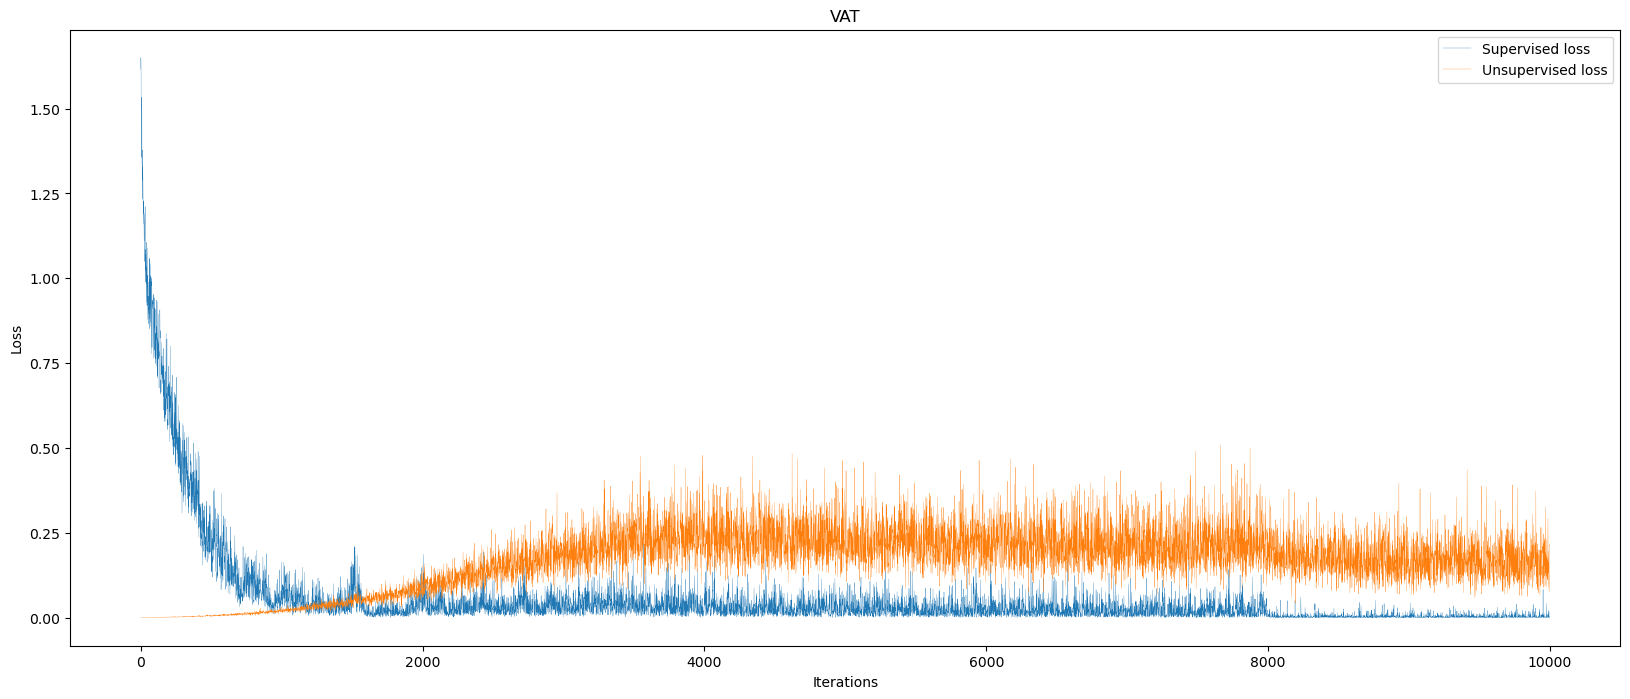

In [111]:
plt.figure(figsize=(20,8))
plt.title("VAT")
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.plot(list(map(float, VAT_cls_loss_list)), linewidth=0.2, label='Supervised loss')
plt.plot(list(map(float, VAT_ssl_loss_list)), linewidth=0.2, label='Unsupervised loss')
plt.legend()
plt.show()

실험 결과, Supervised Loss의 경우 계속해서 감소하다가 0에 가깝게 수렴하고 있습니다. 여기서 사용된 라벨 데이터의 경우에는 1,000개로 비교적 적은 수이기 때문에 1만번의 iteration으로도 수렴한다고 볼 수 있습니다.

반면 Unsupervised Loss의 경우 학습이 진행되면서 오히려 증가하였고 계속해서 진동하는 모습을 볼 수 있습니다.

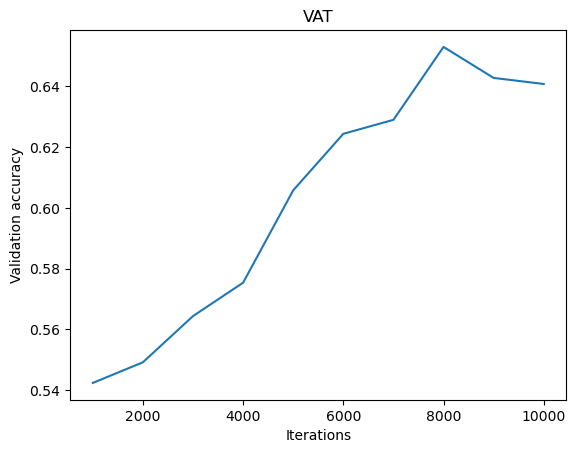

In [116]:
plt.title("VAT")
plt.plot(range(1000, shared_config['iteration']+1, 1000), list(map(float, VAT_val_acc_list)))
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.show()

검증 데이터 셋을 활용한 Accuracy의 경우 계속해서 증가하다가 학습 뒷부분에선 다시 감소하는 모양을 보입니다. 다만 SSL의 경우에는 일반적으로 여기서 실험한 것보다 많은 량의 학습이 필요하므로, 더 학습을 진행한다면 더욱 더 증가 할 가능성도 있습니다.

## 2. Mean Teacher

<img src="https://user-images.githubusercontent.com/35906602/209688575-a6512a9a-9f4d-43eb-884e-b105c70e1477.png" width="1000">

* Reference : https://nuguziii.github.io/paper-review/PR-009/
* Tarvainen and Valpora. Mean teachers are better role models: Weighted-averaged consistency targets improve semi-supervised deep learning results. NIPS 2017

같은 구조를 가지는 2개의 모델 student model과 teacher model이 존재하며, Student model은 labeled data를 Input으로 받으며, teacher model은 unlabeled data를 Input으로 받게 됩니다. 

Student model은 지도 학습 기반의 손실 함수 및 teacher model과의 consistency loss로 학습이 되며, teacher model은 student model의 parameter를 지수 이동 평균하여 update하기 때문에 역전파가 진행되지 않습니다.

### Config

In [18]:
args.alg = 'MT'
mt_config = {
    # mean teacher
    "ema_factor" : 0.95,
    "lr" : 4e-4,
    "consis_coef" : 8,
}
alg_cfg = mt_config

### Model

In [19]:
class MT(nn.Module):
    def __init__(self, model, ema_factor):
        super().__init__()
        self.model = model
        self.model.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1
        y_hat = self.model(x)
        model.update_batch_stats(False)
        y = model(x) # recompute y since y as input of forward function is detached
        model.update_batch_stats(True)
        return (F.mse_loss(y.softmax(1), y_hat.softmax(1).detach(), reduction="none").mean(1) * mask).mean()

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step+1), self.ema_factor)
        for emp_p, p in zip(self.model.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data

In [20]:
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])

trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

trainable parameters : 1467610


Mean Teacher는 Student 모델과 Teacher 모델이 존재하게 됩니다. 

In [21]:
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())
ssl_obj = MT(t_model, alg_cfg["ema_factor"])

### Train

In [22]:
MT_cls_loss_list, MT_ssl_loss_list, MT_loss_list, MT_val_acc_list, MT_test_acc = train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args)

iteration [1000/10000] cls loss : 3.287309e-02, SSL loss : 4.285622e-03, coef : 4.80437e-01, time : 16.888 iter/sec, rest : 8.882 min, lr : 0.0004 
### validation ###
[40/40] time : 144.8 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5419999957084656
### test ###
[70/79] time : 1469.3 data/sec, rest : 0.01 sec 
test accuracy : 0.5482999682426453
iteration [2000/10000] cls loss : 2.020116e-02, SSL loss : 1.580542e-02, coef : 2.29204e+00, time : 16.678 iter/sec, rest : 7.995 min, lr : 0.0004 
### validation ###
[40/40] time : 149.1 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5374000072479248
iteration [3000/10000] cls loss : 8.797040e-03, SSL loss : 3.710358e-02, coef : 5.85293e+00, time : 16.366 iter/sec, rest : 7.128 min, lr : 0.0004 
### validation ###
[40/40] time : 131.5 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5293999910354614
iteration [4000/10000] cls loss : 1.798993e-02, SSL loss : 4.015510e-02, coef : 8.00000e+00, time : 17.360 iter/sec, rest : 5.760 min, 

### Result

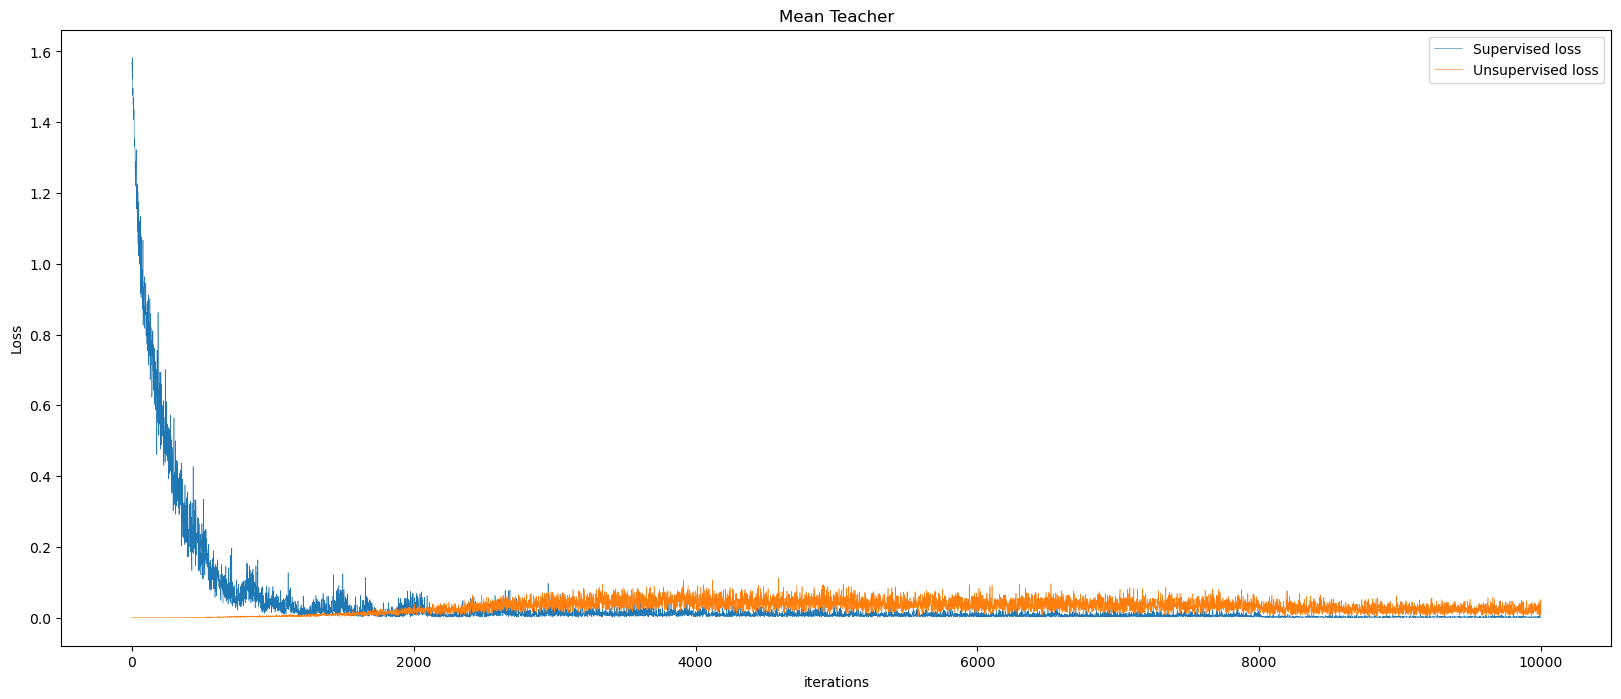

In [112]:
plt.figure(figsize=(20,8))
plt.title("Mean Teacher")
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.plot(list(map(float, MT_cls_loss_list)), linewidth=0.4, label='Supervised loss')
plt.plot(list(map(float, MT_ssl_loss_list)), linewidth=0.4, label='Unsupervised loss')
plt.legend()

앞의 VAT의 경우와 크게 다르지 않은 양상을 보이고 있습니다. 학습이 진행될수록 Supervised Loss의 경우 계속해서 감소하고, Unsupervised Loss의 경우 학습 초반에는 증가하다가 진동하는 모습을 보입니다.

Unsupervised Loss가 VAT의 경우보다 더 작아보일 수 있지만 계산 방식과 스케일의 차이이므로 단순 비교는 힘듭니다.

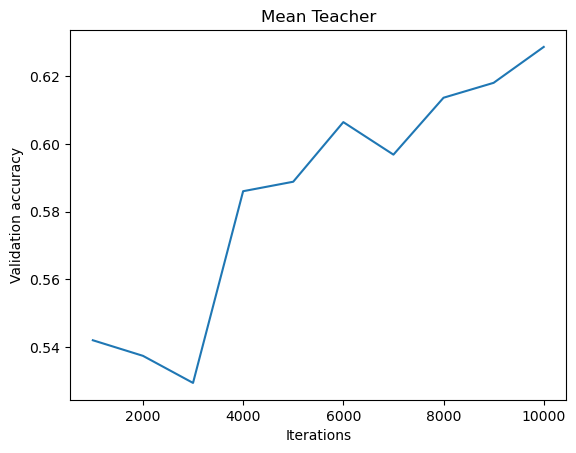

In [117]:
plt.title("Mean Teacher")
plt.plot(range(1000, shared_config['iteration']+1, 1000), list(map(float, MT_val_acc_list)))
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.show()

VAT와는 다르게 학습 후반에도 계속해서 증가하는 모습을 보입니다. 더 학습을 진행한다면 계속해서 성능이 좋아질 것이라고 예상해볼 수 있습니다.

## 3. ${\Pi}$ Model

<img src="https://user-images.githubusercontent.com/35906602/209688968-9a1acdfe-12bb-43d0-b3de-fe02c159c27e.png" width=1000>

* Reference : https://nuguziii.github.io/paper-review/PR-009/
* Laine and Alia. Temporal Ensembling for Semi-Supervised Learning. ICLR 2017

$\Pi$ Model에서는 같은 input에 대해서는 noise가 적용되어도 비슷한 결과를 보여야 한다는 것에서 착안, stochastic augmentation을 각각 다르게 적용합니다. 

Stochastic Augmentation과 Dropout을 이용해 동일한 입력 $x_i$ 에서 다른 출력 $z_i$ 와 $\tilde{z}_i$이 나타납니다.

다만 Training Target이 네트워크의 하나의 evaluation에 의해 얻어지기 때문에 noisy 하다는 문제점이 있습니다.

### Config

In [23]:
args.alg = 'pi'
pi_config = {
    # Pi Model
    "lr" : 3e-4,
    "consis_coef" : 20.0,
}
alg_cfg = pi_config

### Model

In [24]:
class PiModel(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x, y, model, mask):
        # NOTE:
        # stochastic transformation is embeded in forward function
        # so, pi-model is just to calculate consistency between two outputs
        model.update_batch_stats(False)
        y_hat = model(x)
        model.update_batch_stats(True)
        return (F.mse_loss(y_hat.softmax(1), y.softmax(1).detach(), reduction="none").mean(1) * mask).mean()

In [25]:
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])

trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

trainable parameters : 1467610


In [26]:
ssl_obj = PiModel()

### Train

In [27]:
pi_cls_loss_list, pi_ssl_loss_list, pi_loss_list, pi_val_acc_list, pi_test_acc = train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args)

iteration [1000/10000] cls loss : 1.000345e-01, SSL loss : 4.771866e-03, coef : 1.20109e+00, time : 19.079 iter/sec, rest : 7.862 min, lr : 0.0003 
### validation ###
[40/40] time : 138.8 data/sec, rest : 0.00 sec 
varidation accuracy : 0.48639997839927673
### test ###
[70/79] time : 1368.6 data/sec, rest : 0.01 sec 
test accuracy : 0.48829999566078186
iteration [2000/10000] cls loss : 4.253294e-02, SSL loss : 2.206810e-02, coef : 5.73010e+00, time : 18.928 iter/sec, rest : 7.044 min, lr : 0.0003 
### validation ###
[40/40] time : 117.5 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5083999633789062
### test ###
[70/79] time : 1110.1 data/sec, rest : 0.01 sec 
test accuracy : 0.5102999806404114
iteration [3000/10000] cls loss : 6.479893e-02, SSL loss : 8.785844e-02, coef : 1.46323e+01, time : 18.613 iter/sec, rest : 6.268 min, lr : 0.0003 
### validation ###
[40/40] time : 105.2 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5149999856948853
### test ###
[70/79] time : 1161.7 d

### Result

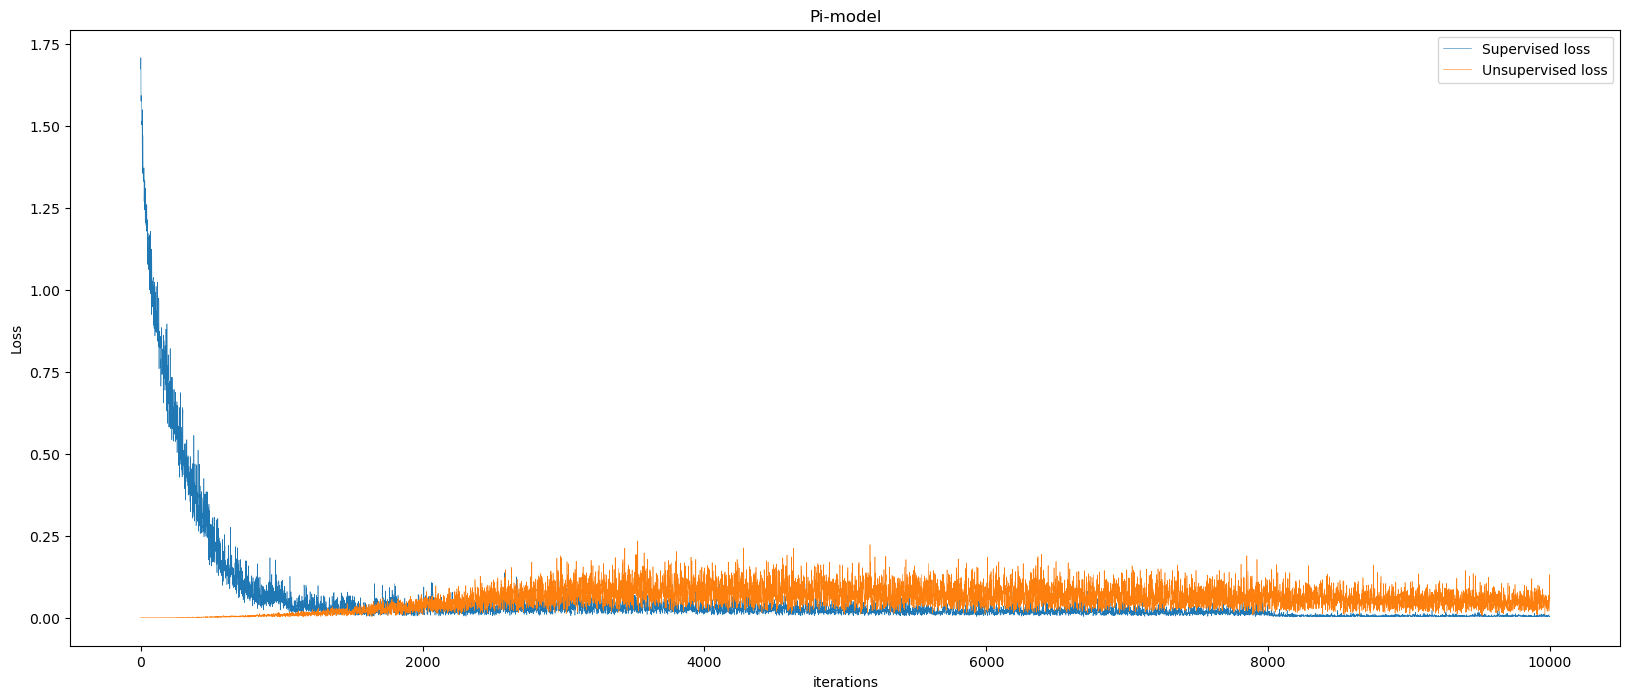

In [113]:
plt.figure(figsize=(20,8))
plt.title("Pi-model")
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.plot(list(map(float, pi_cls_loss_list)), linewidth=0.4, label='Supervised loss')
plt.plot(list(map(float, pi_ssl_loss_list)), linewidth=0.4, label='Unsupervised loss')
plt.legend()

역시 앞의 모델과 마찬가지의 양상을 보이고 있습니다.

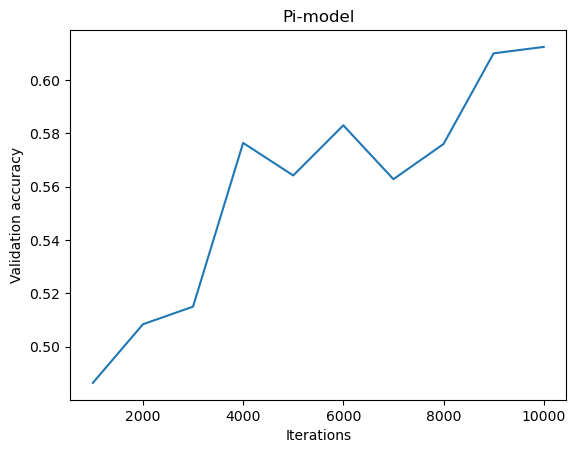

In [118]:
plt.title("Pi-model")
plt.plot(range(1000, shared_config['iteration']+1, 1000), list(map(float, pi_val_acc_list)))
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.show()

Validation 셋으로 구한 Accuracy 역시 MT와 비슷한 양상을 보입니다. 마찬가지로 계속 학습을 진행한다면 성능이 더 좋아질 것이라고 예상 할 수 있습니다.

## 4. ICT

<img src="https://user-images.githubusercontent.com/35906602/209689311-5deeee55-ae48-4fcb-80e6-720febca5e03.png" width="1000">

* Reference : https://jiwunghyun.medium.com/semi-supervised-learning-%EC%A0%95%EB%A6%AC-a7ed58a8f023
* Vikas Verma et al. Interpolation Consistency Training for Semi-Supervised Learning. IJCAI 2019

Mixup을 Semi-supervised learning에 적용한 방법입니다. (Mixup한 데이터에 대한 모델 결과)와 (unlabeled sample의 모델 결과의 Mixup) 차이가 consistency loss가 됩니다.

### Config

In [28]:
args.alg = 'ICT'
ict_config = {
    # interpolation consistency training
    "ema_factor" : 0.999,
    "lr" : 4e-4,
    "consis_coef" : 100,
    "alpha" : 0.1,
}
alg_cfg = ict_config

### Model

In [29]:
class ICT(nn.Module):
    def __init__(self, alpha, model, ema_factor):
        super().__init__()
        self.alpha = alpha
        self.mean_teacher = model
        self.mean_teacher.train()
        self.ema_factor = ema_factor
        self.global_step = 0

    def forward(self, x, y, model, mask):
        self.global_step += 1 # for moving average coef
        mask = mask.byte()
        model.update_batch_stats(False)
        mt_y = self.mean_teacher(x).detach()
        u_x, u_y = x[mask], mt_y[mask]
        l_x, l_y = x[mask==0], mt_y[mask==0]
        lam = np.random.beta(self.alpha, self.alpha) # sample mixup coef
        perm = torch.randperm(u_x.shape[0])
        perm_u_x, perm_u_y = u_x[perm], u_y[perm]
        mixed_u_x = lam * u_x + (1 - lam) * perm_u_x
        mixed_u_y = (lam * u_y + (1 - lam) * perm_u_y).detach()
        y_hat = model(torch.cat([l_x, mixed_u_x], 0)) # "cat" indicates to compute batch stats from full batches
        loss = F.mse_loss(y_hat.softmax(1), torch.cat([l_y, mixed_u_y], 0).softmax(1), reduction="none").sum(1)
        # compute loss for only unlabeled data, but loss is normalized by full batchsize
        loss = loss[l_x.shape[0]:].sum() / x.shape[0]
        model.update_batch_stats(True)
        return loss

    def moving_average(self, parameters):
        ema_factor = min(1 - 1 / (self.global_step), self.ema_factor)
        for emp_p, p in zip(self.mean_teacher.parameters(), parameters):
            emp_p.data = ema_factor * emp_p.data + (1 - ema_factor) * p.data


In [30]:
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])

trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

trainable parameters : 1467610


In [31]:
t_model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
t_model.load_state_dict(model.state_dict())
ssl_obj = ICT(alg_cfg["alpha"], t_model, alg_cfg["ema_factor"])

### Train

In [32]:
ict_cls_loss_list, ict_ssl_loss_list, ict_loss_list, ict_val_acc_list, ict_test_acc = train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args)

iteration [1000/10000] cls loss : 1.880477e-01, SSL loss : 2.179957e-01, coef : 6.00547e+00, time : 14.836 iter/sec, rest : 10.111 min, lr : 0.0004 
### validation ###
[40/40] time : 107.4 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5181999802589417
### test ###
[70/79] time : 1040.7 data/sec, rest : 0.01 sec 
test accuracy : 0.5108999609947205
iteration [2000/10000] cls loss : 3.165285e-01, SSL loss : 7.561034e-01, coef : 2.86505e+01, time : 14.322 iter/sec, rest : 9.310 min, lr : 0.0004  
### validation ###
[40/40] time : 76.3 data/sec, rest : 0.00 sec 
varidation accuracy : 0.515999972820282
iteration [3000/10000] cls loss : 3.478536e-01, SSL loss : 1.699206e+00, coef : 7.31616e+01, time : 13.784 iter/sec, rest : 8.464 min, lr : 0.0004 
### validation ###
[40/40] time : 85.4 data/sec, rest : 0.00 sec 
varidation accuracy : 0.5546000003814697
### test ###
[70/79] time : 812.3 data/sec, rest : 0.01 sec 
test accuracy : 0.5537999868392944
iteration [4000/10000] cls loss : 3.9473

### Result

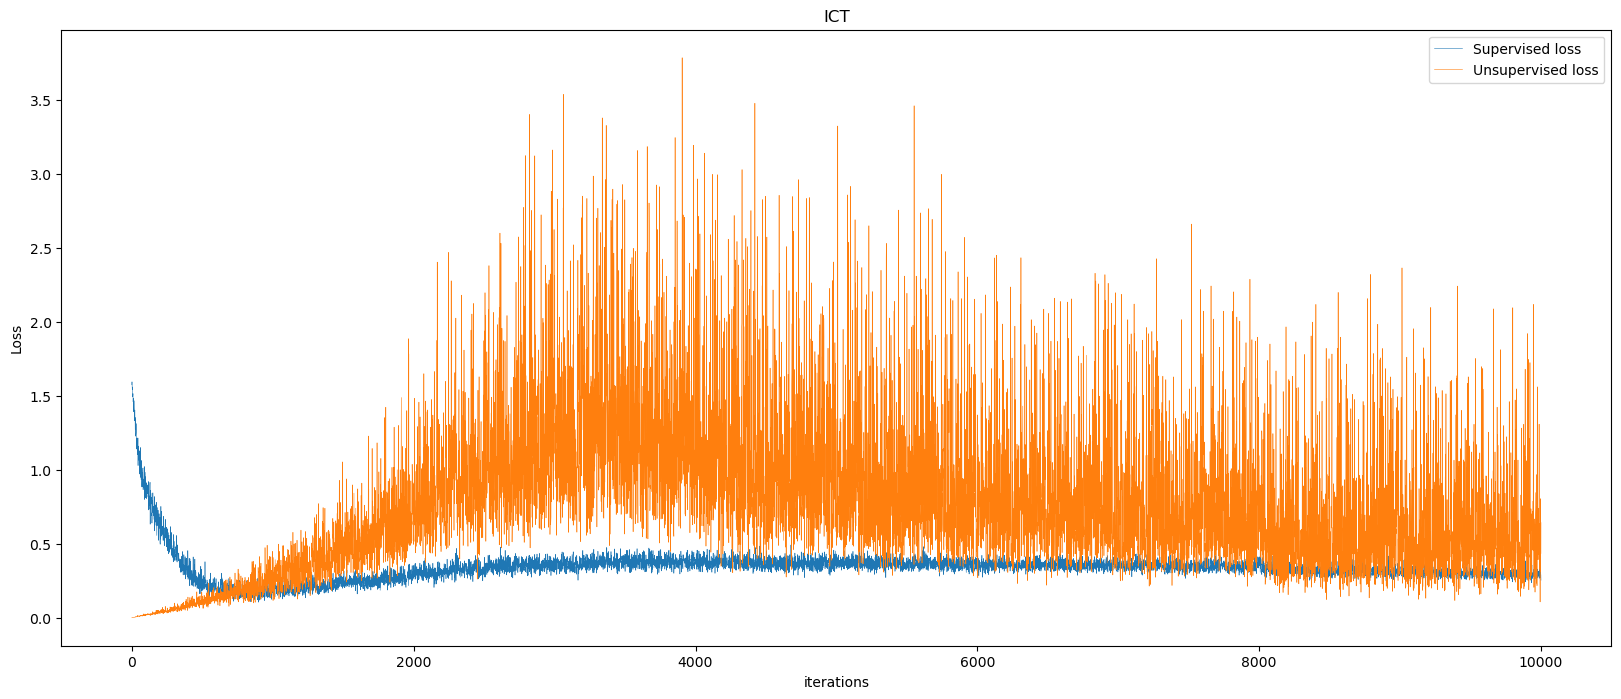

In [114]:
plt.figure(figsize=(20,8))
plt.title("ICT")
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.plot(list(map(float, ict_cls_loss_list)), linewidth=0.4, label='Supervised loss')
plt.plot(list(map(float, ict_ssl_loss_list)), linewidth=0.4, label='Unsupervised loss')
plt.legend()

ICT는 앞선 3개의 모델과는 다소 다른 양상을 보이고 있습니다. Supervised Loss의 경우 다른 모델과는 다르게 0으로 수렴하기보다는 다시 증가했다가 어느정도 수준에서 작게 진동하는 모습을 보입니다.

Unsupervised Loss의 경우에는 학습 초반에 iteration이 진행될수록 진동하는 폭이 점점 커지다가 후반에는 다시 진동폭이 약간이나마 작아지는 모습을 보이고 있습니다.

학습을 더 많이 진행한다면 다른 양상을 보일 수 있을 것 같습니다.

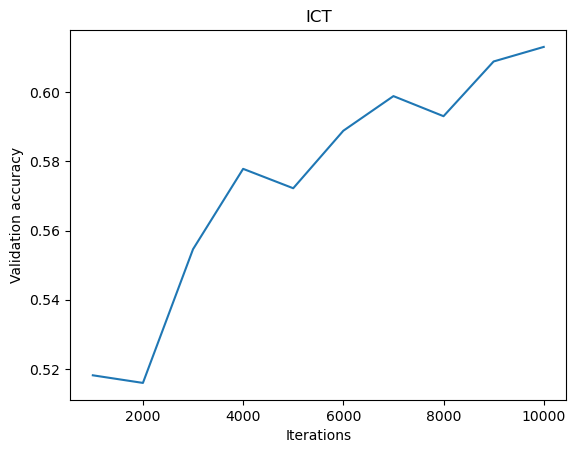

In [119]:
plt.title("ICT")
plt.plot(range(1000, shared_config['iteration']+1, 1000), list(map(float, ict_val_acc_list)))
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.show()

Validation 셋으로 구한 Accuracy의 경우 위의 3 모델보다 다소 낮은 모습을 보이고 있습니다. 하지만 마찬가지로 꾸준히 우상향하는 모양새이므로 더 많은 학습을 진행한다면 성능이 계속 높아질 것이라고 예상 할 수 있습니다.

## 5. MixMatch

<img src="https://user-images.githubusercontent.com/35906602/209689424-e0675460-c8ac-473e-9286-1713a9f8cf28.png" width="900">

* Reference : https://jiwunghyun.medium.com/semi-supervised-learning-%EC%A0%95%EB%A6%AC-a7ed58a8f023
* David Berthelot et al. MixMatch: A Holistic Approach for Semi-Supervised Learning. NeurIPS 2019.

앞에 나온 entropy minimization, label consistency regularization, mixup을 모두 적용한 방법입니다. MixMatch는 labeled data와 unlabeled data를 받아서 결합된 데이터를 만듭니다.

Unlabeled data에 대하여 K번의 augmentation을 하고 prediction의 평균을 구하고 그 값을 temperature sharpening을 통하여 sharpen 하며, Augmentation된 labeled, unlabeled 데이터를 섞고, 그 데이터에 대하여 labeled data와 unlabeled data에 MixUp을 합니다.

학습은 다른 모델과 같이 supervised loss는 CE, unsupervised loss는 모델 출력 값의 차이 (L2)가 됩니다.

### Config

In [33]:
args.alg = 'MM'
mm_config = {
    # mixmatch
    "lr" : 3e-3,
    "consis_coef" : 100,
    "alpha" : 0.75,
    "T" : 0.5,
    "K" : 2,
}
alg_cfg = mm_config

### Model

In [34]:
class MixMatch(nn.Module):
    def __init__(self, temperature, n_augment, alpha):
        super().__init__()
        self.T = temperature
        self.K = n_augment
        self.beta_distirb = torch.distributions.beta.Beta(alpha, alpha)

    def sharpen(self, y):
        y = y.pow(1/self.T)
        return y / y.sum(1,keepdim=True)

    def forward(self, x, y, model, mask):
        # NOTE: this implementaion uses mixup for only unlabeled data
        model.update_batch_stats(False)
        u_x = x[mask == 1]
        # K augmentation and make prediction labels
        u_x_hat = [u_x for _ in range(self.K)]
        y_hat = sum([model(u_x_hat[i]).softmax(1) for i in range(len(u_x_hat))]) / self.K
        y_hat = self.sharpen(y_hat)
        y_hat = y_hat.repeat(len(u_x_hat), 1)
        # mixup
        u_x_hat = torch.cat(u_x_hat, 0)
        index = torch.randperm(u_x_hat.shape[0])
        shuffled_u_x_hat, shuffled_y_hat = u_x_hat[index], y_hat[index]
        lam = self.beta_distirb.sample().item()
        # lam = max(lam, 1-lam)
        mixed_x = lam * u_x_hat + (1-lam) * shuffled_u_x_hat
        mixed_y = lam * y_hat + (1-lam) * shuffled_y_hat.softmax(1)
        # mean squared error
        loss = F.mse_loss(model(mixed_x), mixed_y)
        model.update_batch_stats(True)
        return loss

In [35]:
model = wrn.WRN(2, dataset_cfg["num_classes"], transform_fn).to(device)
optimizer = optim.Adam(model.parameters(), lr=alg_cfg["lr"])

trainable_paramters = sum([p.data.nelement() for p in model.parameters()])
print("trainable parameters : {}".format(trainable_paramters))

trainable parameters : 1467610


In [36]:
ssl_obj = MixMatch(alg_cfg["T"], alg_cfg["K"], alg_cfg["alpha"])

### Train

In [37]:
mm_cls_loss_list, mm_ssl_loss_list, mm_loss_list, mm_val_acc_list, mm_test_acc = train_ssl(l_loader, u_loader, val_loader, test_loader, ssl_obj, optimizer, shared_config, alg_cfg, args)

iteration [1000/10000] cls loss : 1.299180e+00, SSL loss : 4.181144e-02, coef : 6.00547e+00, time : 6.355 iter/sec, rest : 23.605 min, lr : 0.003 
### validation ###
[40/40] time : 77.4 data/sec, rest : 0.00 sec 
varidation accuracy : 0.42319998145103455
### test ###
[70/79] time : 684.4 data/sec, rest : 0.01 sec 
test accuracy : 0.42179998755455017
iteration [2000/10000] cls loss : 1.524980e+00, SSL loss : 6.239379e-03, coef : 2.86505e+01, time : 6.938 iter/sec, rest : 19.218 min, lr : 0.003 
### validation ###
[40/40] time : 50.5 data/sec, rest : 0.00 sec 
varidation accuracy : 0.19859999418258667
iteration [3000/10000] cls loss : 1.519659e+00, SSL loss : 1.028121e-02, coef : 7.31616e+01, time : 6.795 iter/sec, rest : 17.168 min, lr : 0.003 
### validation ###
[40/40] time : 59.8 data/sec, rest : 0.00 sec 
varidation accuracy : 0.4179999828338623
iteration [4000/10000] cls loss : 1.486870e+00, SSL loss : 5.600277e-02, coef : 1.00000e+02, time : 6.662 iter/sec, rest : 15.011 min, lr :

### Result

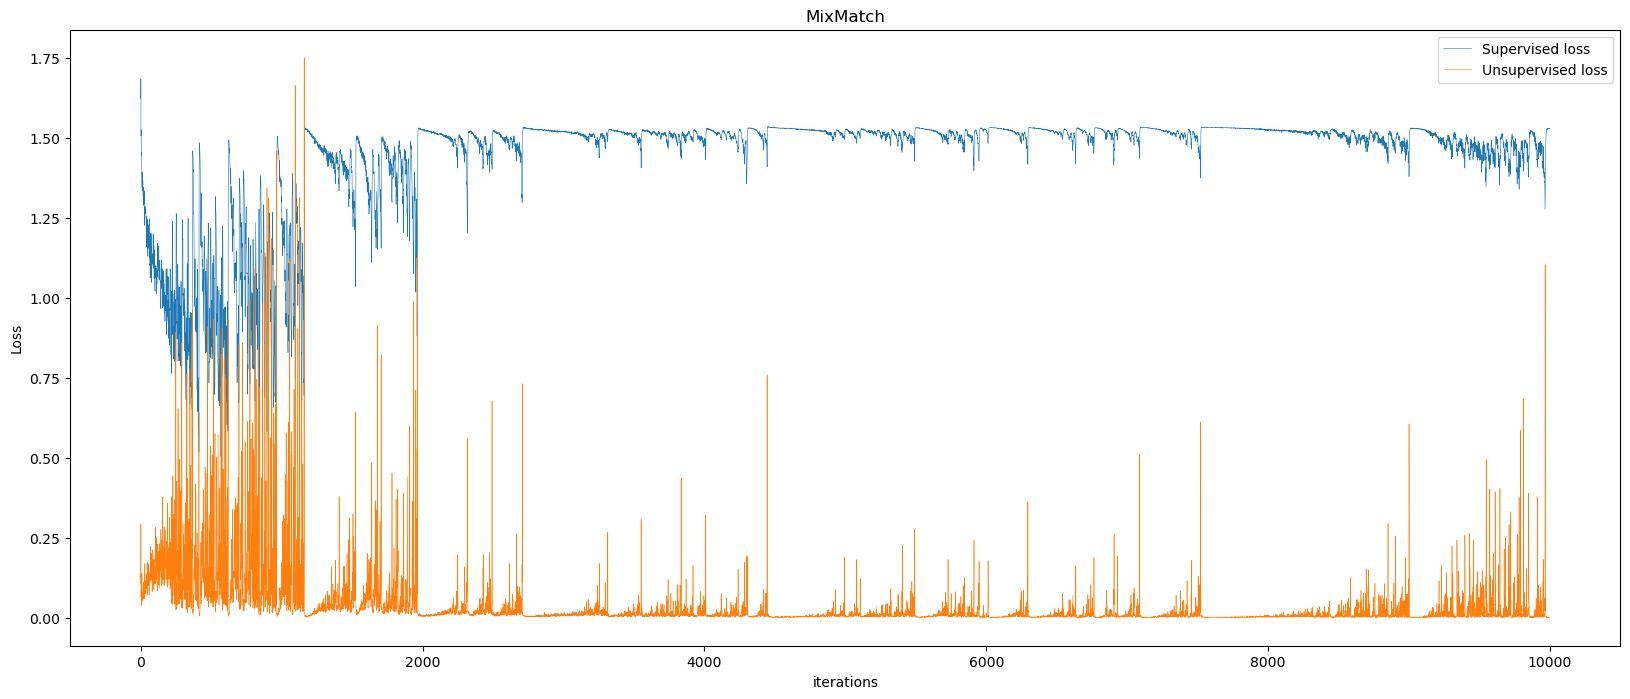

In [120]:
plt.figure(figsize=(20,8))
plt.title("MixMatch")
plt.ylabel('Loss')
plt.xlabel('iterations')
plt.plot(list(map(float, mm_cls_loss_list)), linewidth=0.4, label='Supervised loss')
plt.plot(list(map(float, mm_ssl_loss_list)), linewidth=0.4, label='Unsupervised loss')
plt.legend()

위의 4개의 모델과는 매우 다른 모습을 보이고 있습니다. MixMatch의 경우 다양한 SSL 방법론을 차용하여 섞은 모델이기 때문에 각 방법론의 특징이 반영된 결과라고 볼 수 있습니다.

다만 Supervised Loss가 지나치게 높고, 감소하는 추세를 보이고 있지도 않으며, Unsupervised Loss 역시 비슷한 모습을 보이고 있습니다.

다른 방법론에 비해 더 많은 학습이 필요해보입니다.

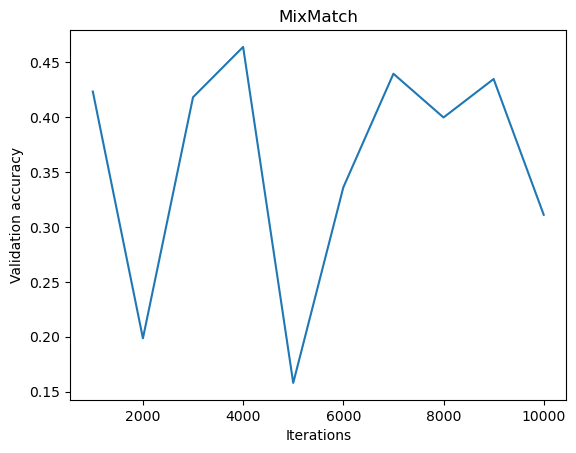

In [98]:
plt.title("MixMatch")
plt.plot(range(1000, 10001, 1000), list(map(float, mm_val_acc_list)))
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.show()

Validation set으로 구한 성능 역시 학습 초반과 후반에 큰 차이가 없습니다. 

## 6. 정리 및 결론

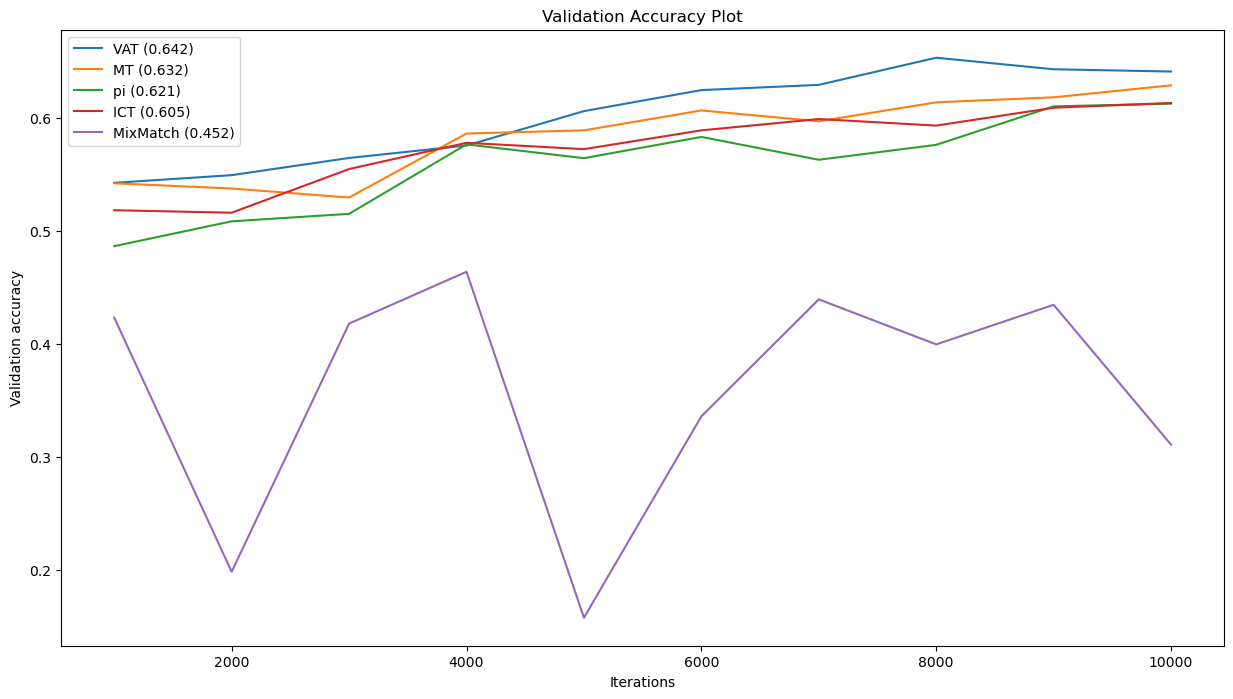

In [107]:
plt.figure(figsize=(15,8))
plt.title("Validation Accuracy Plot")
plt.ylabel('Validation accuracy')
plt.xlabel('Iterations')
plt.plot(range(1000, 10001, 1000), list(map(float, VAT_val_acc_list)), label=f'VAT ({round(float(VAT_test_acc),3)})')
plt.plot(range(1000, 10001, 1000), list(map(float, MT_val_acc_list)), label=f'MT ({round(float(MT_test_acc),3)})')
plt.plot(range(1000, 10001, 1000), list(map(float, pi_val_acc_list)), label=f'pi ({round(float(pi_test_acc),3)})')
plt.plot(range(1000, 10001, 1000), list(map(float, ict_val_acc_list)), label=f'ICT ({round(float(ict_test_acc),3)})')
plt.plot(range(1000, 10001, 1000), list(map(float, mm_val_acc_list)), label=f'MixMatch ({round(float(mm_test_acc),3)})')
plt.legend()
plt.show()

위 plot에서 legend의 괄호 안에 있는 수치는 최종적으로 Test set에 대해 검증한 Accuracy 점수를 의미합니다.

VAT, MT, pi, ICT, MixMatch 순으로 좋은 성능을 보였습니다.

일반적으로 Unlabeled 데이터의 경우 오랜 학습을 통해 데이터의 특징을 파악 할 필요가 있다고 알려져 있습니다. 기존 논문들의 경우 학습 Iteration을 500,000 정도로 학습시키지만 본 튜토리얼에서는 시간상의 문제로 그에 비해 매우 적은 10,000번만의 Iteration으로 학습을 시켰습니다.

전체적으로 학습을 더 많이 진행한다면 성능이 더 향상 될 수 있을 것으로 보입니다.

다만 MixMatch의 경우 다른 모델과는 다르게 뚜렷한 상승세를 보이고 있지도 않으며, 위에서 학습이 굉장히 불안정하게 된 것을 확인할 수 있었습니다. 

훨씬 많은 학습을 통해 MixMatch의 성능 plot이 변화하는 모습을 관찰 할 필요가 있으며, 다양한 하이퍼 파라미터가 있으므로 튜닝 등이 필요할 것으로 보입니다.